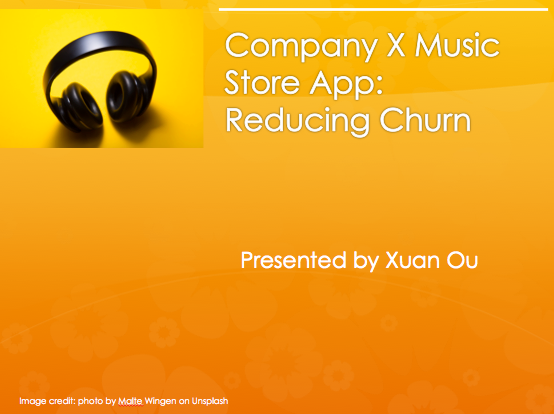

In [12]:
Image(filename='/Users/xuanou/Documents/2018Git/Music-Store-App-Project/CompanyX.png') 

# Introduction

In this report I present findings from an exploration of a Music Store App user dataset which records users behavior including playing , searching and downloading songs using the App. Of primary interest is user churn prediction, that means detecting which/when users are likely to stop using the App [1].

Why churn modeling?
* On average 65% of company’s business comes from existing customers and acquiring the new ones is **15** times more expensive than retaining existing customers [2]. 
* It will be able to help marketers to interventing with users at risk of churn (e.g. email, reminder, promotions etc).
* It will be instructive for future app design

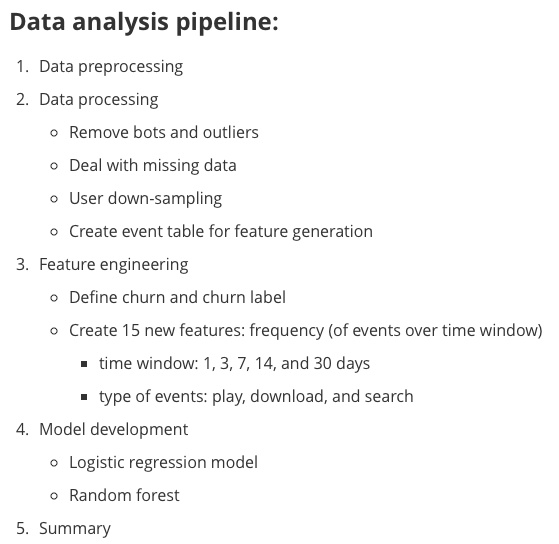

In [3]:
Image(filename='/Users/xuanou/Desktop/data/data_pipeline.png') 

# Data processing

The source data was provided by a tech company in China, which includes play log, search log, and download log files from **3/30/2017 - 5/12/2017**. The play log file contains **100,000,000+** records.
The search log contains 8,000,000+ records. And the download log file contains 7,000,000+ records. There is no user profile available. The dataset covers about 0.6 million distinct users and 2 million songs.

## Date preprocessing

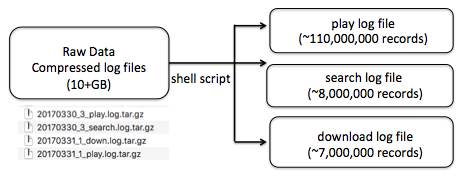

In [6]:
Image(filename='/Users/xuanou/Desktop/data/data.png') 

* unpacked compressed log files
* combined each seperate log file to one log file
* appened file_name to each row, therefore date was added to the original dataset as a new column

Due to the large size of the data (~10GB), the files were first unpacked, and the log files were preprocessed using shell script. In addition, since the log files are recorded by each day, I also combined seperate log files to one file containing all the records between 3/30/2017 - 5/12/2017.

In [ ]:
#### process play log files ####
# unzip play log
cd ../data/raw/
for f in *_play.log.tar.gz
do
 echo "Processing $f"
 tar -xvzf $f 
done

mv *_play.log ../play/

# append file_name to each row (date is added to the dataset)
cd ../play/
for f in *.log
do
 echo "Processing $f"
 awk -v var="$f" '{print $0,"\t",substr(var,1,8)}' $f > ${f}.fn
done

# cat all log with filename to one file
cat *.log.fn > all_play_log
rm *.log
rm *.log.fn



#### process down log files ####
# unzip down log
cd ../data/raw/
for f in *_down.log.tar.gz
do
 echo "Processing $f"
 tar -xvzf $f && mv *_down.log  ../down/${f//".tar.gz"/""}
done

# append file_name to each row (date is added to the dataset)
cd ../down/
for f in *.log
do
 echo "Processing $f"
 awk -v var="$f" '{print $0,"\t",substr(var,1,8)}' $f > ${f}.fn
done

# cat all log with filename to one file
cat *.log.fn > all_down_log
rm *.log
rm *.log.fn



#### process search log files ####
# unzip search log
cd ../data/raw/
for f in *_search.log.tar.gz
do
 echo "Processing $f"
 tar -xvzf $f && mv *_search.log  ../search/${f//".tar.gz"/""}
done

# append file_name to each row (date is added to the dataset)
cd ../search/
for f in *.log
do
 echo "Processing $f"
 awk -v var="$f" '{print $0,"\t",substr(var,1,8)}' $f > ${f}.fn
done

# cat all log with filename to one file
cat *.log.fn > all_search_log
rm *.log
rm *.log.fn

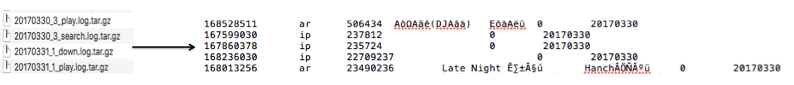

In [9]:
Image(filename='/Users/xuanou/Desktop/data/data_preprocessing_1.png') 

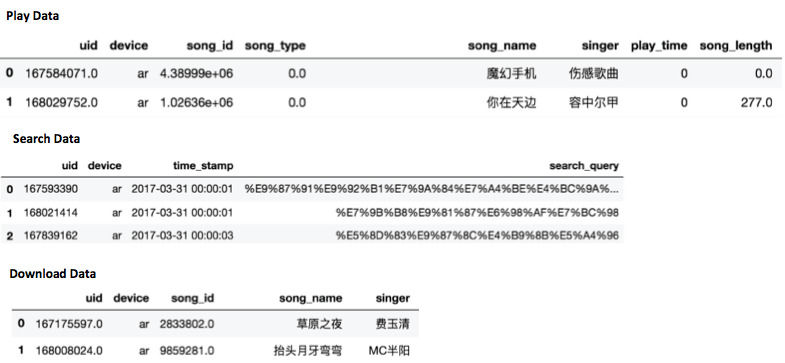

In [12]:
Image(filename='/Users/xuanou/Desktop/data/data_preprocessing_2.png') 

## Remove bots and outliers

### Count unique user IDs in the dataset

In [1]:
# use shell script to count plays group by each user id
import os
cmd="""
export LC_CTYPE=C 
export LANG=C
# get uid field| sort | count unique ids | strip blank spaces | output to file
cat /Users/xuanou/Desktop/data/play/all_play_log| cut -f1 -d$'\t'| sort | uniq -c | sed -e 's/^ *//g;s/ *$//g'> /Users/xuanou/Desktop/data/uid_count.csv
"""
os.system(cmd)

0

In [2]:
import numpy as np                        # vectors and matrices
import pandas as pd                       # tables and data manipulations
import matplotlib.pyplot as plt           # plots
from matplotlib.dates import date2num     # working with dates
import seaborn as sns                     # more plots
from IPython.display import Image         # displaying images

import warnings                           # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('ggplot')

In the following, I used Python numpy and pandas library to perform data wrangling, and audit data quality. I also used Tableau, seaborn and matplotlib to perform data exploration and visualization.

Remember that the play log file has over one hundred million records. The whole dataset is too large to handle in personal laptop, therefore I decided to down sampleing the data at user level so that it would be able to run on personal laptop. By this way, we lose much less information and ensure that randomly selected subgroup is adequately representative within the whole sample population.
1. Get all the distinct user_ids
2. Remove bots and outliers
3. Down-sample user_ids and put into set
4. Pass data once and keep only if user_id in the set

I first counted how many times each distinct user played music in the play dataset, which is the largest dataset among three of those and found that there are **594,734 distinct** users played music during that period of time. I also noted that there is **1 user id** missing.

In [8]:
# read play counts data by each user ID
df = pd.read_csv('/Users/xuanou/Desktop/data/uid_count.csv',sep='\s+', names=['count','uid'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594735 entries, 0 to 594734
Data columns (total 2 columns):
count    594735 non-null int64
uid      594734 non-null float64
dtypes: float64(1), int64(1)
memory usage: 9.1 MB


In [4]:
# generates descriptive statistics
df.describe()

,count,uid
count,5.947350e+05,5.947340e+05
mean,2.460525e+02,1.673628e+08
std,1.526662e+04,1.047142e+07
min,1.000000e+00,0.000000e+00
25%,9.000000e+00,1.680262e+08
50%,4.000000e+01,1.684782e+08
75%,1.740000e+02,1.687685e+08
max,7.501794e+06,1.692623e+08


Next, I checked the user counts of play times. I'd like to check whether the maximum of play counts is resonable or not.

### Remove bots and outliers

Due to large variation between times of user play, I transformed the data by taking the log of the play counts and made a plot of log(play_counts). From the plot, I noted that there is a few users that played songs ~10,000 times, which looked to me like bots.

Text(0.5,0,'user # plays (10^n)')

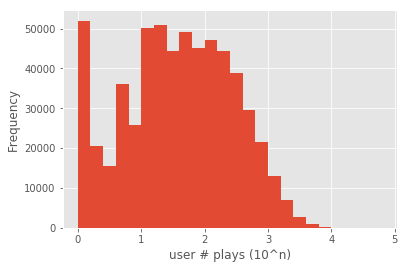

In [9]:
# make a plot of log(play_counts)
np.log10(df['count']).plot.hist(bins=np.arange(0,5,0.2))
plt.xlabel("user # plays (10^n)")

So we need to remove bot users. The startegy I used to keep bots out is based on the following logic. It's reported that the average length of a song is abut 3 minutes. Let's assume a person plays music 8 hours per day, that's 8 X60 mins which equals 480 mins. So he/she will listen 160 songs per day. We have 44 days (3/30/17-5/12/17). Therefore, we estimate that he/she can listen (44* 160) songs ~ 7000 songs during data analysis window. Then I checked 99.9th percentile of play_counts, which equals 5195.394. I decided to set the threshold to 99.9%, and removed the 0.1% users. In addition, I deleted one record with missing user id.

In [7]:
# 99.9% percentile of play_counts

top_count_threshold = np.percentile(df['count'],99.9)
print(top_count_threshold)

5195.394000000553


In [8]:
# remove bots: get id with play counts < top_count_threshold
id_list_bot_removed = np.array(df['uid'][df['count']<top_count_threshold].dropna())

print("total number of users after bot removed:",len(id_list_bot_removed))

total number of users after bot removed: 594139


We removed **596 records (594735 - 594139 = 596)** including both outliers and one missing value.

## Apply downsmaple on user id level

* Down-sample user_ids and put into set
* Convert date to date type
* Pass data once and keep only if user_id in the set
* Delete irrelevant features

In [10]:
"""
downsampling ids using down sample ratio = 0.1

"""
# downsample ids
np.random.seed = 1
down_sample_ratio = 0.1
id_subset = set(id_list_bot_removed[np.random.random(id_list_bot_removed.shape)<down_sample_ratio])

print("total number of users after down sample:",len(id_subset))

total number of users after down sample: 59107


After downsampling, we have **59107 distinct** user ids.

In [11]:
# define date conversion function
import datetime
def convert_date(s):
    s = str(s).strip()  #leading spaces are removed
    try:
        year = int(s[:4])
        month = int(s[4:6])
        day = int(s[6:8])
        return datetime.date(year,month,day)
    except:
        return None

In [10]:
"""
only keep the search information for user ids retained in the 
play dataset after down-sampling
"""

# downsample search dataset by uid  
import csv
input_file = '/Users/xuanou/Desktop/data/search/all_search_log'
output_file = '/Users/xuanou/Desktop/data/search_ds.csv'
input_field_list = ['uid','device','time_stamp','search_query','date']
output_field_list = ['uid','device','date']            # only keep relevant features
i=0
with open(input_file,'r',encoding='latin-1') as fin, open(output_file,'w') as fout:
    csvin = csv.DictReader(fin,delimiter='\t',fieldnames=input_field_list,quoting=csv.QUOTE_NONE)  # mapping each row to fieldnames
    csvout = csv.writer(fout,delimiter=',')
    csvout.writerow(output_field_list) # write header
    for row in csvin:
        i+=1
        if i%1000000==0:
            print("#row processed:",i)
        try:
            int(row['uid'])
        except:
            continue
        if int(row['uid']) in id_subset:
            row['date'] = convert_date(row['date'])         # use defined convert_date function to convert to date type
            if row['date'] != None: 
                csvout.writerow([str(row[key]).strip() for key in output_field_list])

NameError: name 'id_subset' is not defined

In [14]:
"""
only keep the download information for uids retained in the 
play dataset after down-sampling
"""

# downsample download dataset by uid
import csv
input_file = '/Users/xuanou/Desktop/data/down/all_down_log'
output_file = '/Users/xuanou/Desktop/data/down_ds.csv'
input_field_list = ['uid','device','song_id','song_name','singer','date']
output_field_list = ['uid','device','song_id','date']
i=0
with open(input_file,'r',encoding='latin-1') as fin, open(output_file,'w') as fout:
    csvin = csv.DictReader(fin,delimiter='\t',fieldnames=input_field_list,quoting=csv.QUOTE_NONE)
    csvout = csv.writer(fout,delimiter=',')
    csvout.writerow(output_field_list) # write header
    for row in csvin:
        i+=1
        if i%1000000==0:
            print("#row processed:",i)
        try:
            int(row['uid'])
        except:
            continue
        if int(row['uid']) in id_subset:
            row['date'] = convert_date(row['date'])     
            if row['date'] != None: 
                csvout.writerow([str(row[key]).strip() for key in output_field_list])

#row processed: 1000000
#row processed: 2000000
#row processed: 3000000
#row processed: 4000000
#row processed: 5000000
#row processed: 6000000
#row processed: 7000000


In [6]:
# Take a quick look at three datasets after down-sampling
df_play = pd.read_csv('/Users/xuanou/Desktop/data/play_ds.csv')
df_play.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10745731 entries, 0 to 10745730
Data columns (total 6 columns):
uid            int64
device         object
song_id        object
date           object
play_time      object
song_length    float64
dtypes: float64(1), int64(1), object(4)
memory usage: 491.9+ MB


In [17]:
df_play.head()

,uid,device,song_id,date,play_time,song_length
0,168540348,ar,77260,2017-03-30,64528,0.0
1,168547857,ar,4.3563e+06,2017-03-30,3,0.0
2,168548101,ip,6.91318e+06,2017-03-30,40,198.0
3,168551487,ar,811133,2017-03-30,200,200.0
4,168532776,ip,2.06741e+07,2017-03-30,172,172.0


In [18]:
df_search = pd.read_csv('/Users/xuanou/Desktop/data/search_ds.csv')
df_search.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763366 entries, 0 to 763365
Data columns (total 3 columns):
uid       763366 non-null int64
device    763366 non-null object
date      763366 non-null object
dtypes: int64(1), object(2)
memory usage: 17.5+ MB


In [27]:
df_search.head()

,uid,device,date
0,168040163,ar,2017-03-30
1,168045723,ar,2017-03-30
2,167780192,ar,2017-03-30
3,168045723,ar,2017-03-30
4,168021965,ar,2017-03-30


In [19]:
df_down = pd.read_csv('/Users/xuanou/Desktop/data/down_ds.csv')
df_down.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623240 entries, 0 to 623239
Data columns (total 4 columns):
uid        623240 non-null int64
device     623240 non-null object
song_id    623169 non-null float64
date       623240 non-null object
dtypes: float64(1), int64(1), object(2)
memory usage: 19.0+ MB


In [28]:
df_down.head()

,uid,device,song_id,date
0,167580727,ip,6298828.0,2017-03-30
1,167819030,ip,365492.0,2017-03-30
2,167819030,ip,6854227.0,2017-03-30
3,167819030,ip,3626250.0,2017-03-30
4,167819030,ip,914553.0,2017-03-30


After downsampling, the counts of records for each dataset are listed below:
* Play data: 10745731
* Search data: 763366
* Download datas: 623240

## Create event table for feature generation

After getting three datasets after downsampling, I combined play, search and download datasets into one user behavior table in order to generate new features.

In [20]:
play_file = '/Users/xuanou/Desktop/data/play_ds.csv'
down_file = '/Users/xuanou/Desktop/data/down_ds.csv'
search_file = '/Users/xuanou/Desktop/data/search_ds.csv'
output_file = '/Users/xuanou/Desktop/data/event_ds.csv'
play_field_list = ['uid','device','song_id','date','play_time','song_length']
down_field_list = ['uid','device','song_id','date']
search_field_list = ['uid','device','date']
output_field_list = ['uid','event','song_id','date']
with open(play_file,'r') as f_play, open(down_file,'r') as f_down, \
open(search_file,'r') as f_search,open(output_file,'w') as f_out:
    csvplay = csv.DictReader(f_play,delimiter=',')
    csvdown = csv.DictReader(f_down,delimiter=',')
    csvsearch = csv.DictReader(f_search,delimiter=',')
    csvout = csv.writer(f_out,delimiter=',')
    csvout.writerow(output_field_list) # write header
    print('Processing play ...')
    for row in csvplay:
        row['event'] = 'P'
        row['date']
        csvout.writerow([row[key] for key in output_field_list])
    print('Processing down ...')
    for row in csvdown:
        row['event'] = 'D'
        csvout.writerow([row[key] for key in output_field_list])
    print('Processing search ...')
    for row in csvsearch:
        row['event'] = 'S'
        csvout.writerow([row.get(key,'') for key in output_field_list])

Processing play ...
Processing down ...
Processing search ...


In [17]:
# Take a quick look at event table
df_event = pd.read_csv('/Users/xuanou/Desktop/data/event_ds.csv')

In [18]:
df_event.isnull().sum()

uid             0
event           0
song_id    767649
date            0
dtype: int64

# Feature Generation and labeling

In [2]:
import pyspark.sql.functions as F
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import col,sum
sc = SparkContext('local')
spark = SparkSession(sc)

After data wrangling, I first used pyspark sql to audit data integrity.

In [3]:
# Load data into Spark DataFrame
df = spark.read.csv('/Users/xuanou/Desktop/data/event_ds.csv',header=True).cache()
df

DataFrame[uid: string, event: string, song_id: string, date: string]

In [64]:
df.show(10)

+---------+-----+--------+----------+
|      uid|event| song_id|      date|
+---------+-----+--------+----------+
|168540348|    P|   77260|2017-03-30|
|168547857|    P| 4356304|2017-03-30|
|168548101|    P| 6913185|2017-03-30|
|168551487|    P|  811133|2017-03-30|
|168532776|    P|20674091|2017-03-30|
|168548099|    P| 4984002|2017-03-30|
|168543049|    P|  347730|2017-03-30|
|168550576|    P|  324249|2017-03-30|
|168551383|    P| 7149583|2017-03-30|
|168543348|    P|       0|2017-03-30|
+---------+-----+--------+----------+
only showing top 10 rows



In [65]:
# create new or overwrite original field with withColumn
df = df.withColumn('date',F.col('date').cast('date'))
df

DataFrame[uid: string, event: string, song_id: string, date: date]

In [25]:
df.count()

12132337

There are **59106** distinct uids, which is consistent with the records before data wrangling.

In [26]:
# select operation, count distinct rows
df.select('uid').distinct().count()

59106

The counts for each event including playing, searching, and downloading are also consistent with previous records.

In [29]:
# group by aggregation
df.groupBy('event').count().show()

+-----+--------+
|event|   count|
+-----+--------+
|    D|  623240|
|    S|  763366|
|    P|10745731|
+-----+--------+



In [68]:
date_count = df.groupBy('date').count().toPandas()
date_count['date'] = date_count['date'].apply(date2num) 

Let's take a look at the trend of DAU.

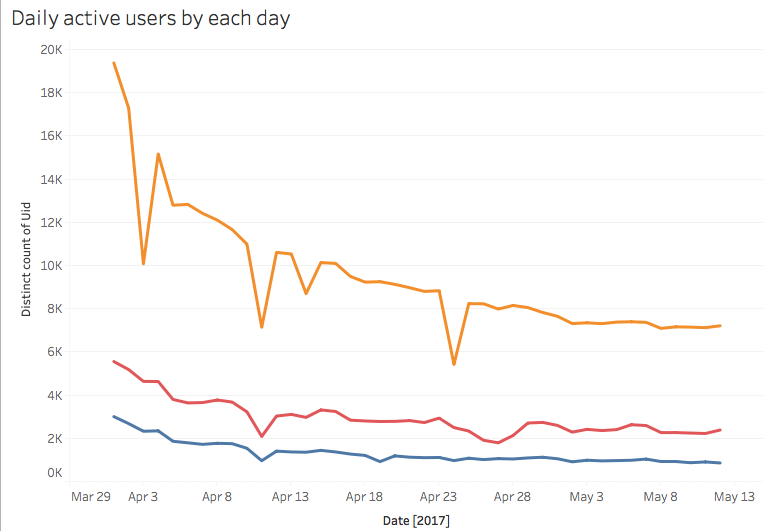

In [13]:
Image(filename='/Users/xuanou/Desktop/data/Counts_eachday.png') 

In the first week, the active users were at least 2X times more than the rest of days. It needed to investigate to get more insights. It shows us the downtrend of DAU.


After checking data integrity, I did the following feature engineering:

1. Define churn and churn label
2. Create 15 new features: frequency (of events over time window)
  - time window: 1, 3, 7, 14, and 30 days
  - type of events: play, download, and search

## Churn Label

Here I defined user churn if users were inactive in outcome window of last two weeks (4/29-5/12). Then the population included all active users between 3/30-4/28.

In [10]:
# Create label window (2017-04-29 ~ 2017-05-12) and feature windown (2017-03-30 ~ 2017-04-28)
import datetime
from dateutil import parser

label_window_size = 14
label_window_end_date = parser.parse('2017-05-12').date()
label_window_start_date = label_window_end_date - datetime.timedelta(label_window_size - 1)
print('label window:',label_window_start_date,'~',label_window_end_date,'days:',label_window_size)

feature_window_size = 30
feature_window_end_date = label_window_start_date - datetime.timedelta(1)
feature_window_start_date = feature_window_end_date  - datetime.timedelta(feature_window_size - 1)
print('feature window:',feature_window_start_date,'~',feature_window_end_date,'days:',feature_window_size)

label window: 2017-04-29 ~ 2017-05-12 days: 14
feature window: 2017-03-30 ~ 2017-04-28 days: 30


In [11]:
# Include all the users in feature window
df_model_uid = df.filter((F.col('date')>=feature_window_start_date) & (F.col('date')<=feature_window_end_date))\
                    .select('uid').distinct()
# active in label window (active/not churn label=0)
df_active_uid_in_label_window = df.filter((F.col('date')>=label_window_start_date) & (F.col('date')<=label_window_end_date))\
                            .select('uid').distinct().withColumn('label',F.lit(0))

**If a user existed in feature window but left in label window, that user was defined as 'churner', and labeled as 1, otherwise the user was labeled as 0.**

In [12]:
# prepare label data (churn label=1; active label=0)
df_label = df_model_uid.join(df_active_uid_in_label_window,on=['uid'],how='left')
df_label = df_label.fillna(1)

In [13]:
df_label.show(5)

+---------+-----+
|      uid|label|
+---------+-----+
|136858556|    1|
|159183409|    0|
|166855134|    0|
|167581827|    1|
|167590080|    1|
+---------+-----+
only showing top 5 rows



In [55]:
df_label.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|35847|
|    0|21939|
+-----+-----+



## Feature generation

What intuitively would make sense for having an effect on user churn?

15 features were generated consisting of frequencies of events over observation window.
* Number of days: 1, 3, 7, 14, 30
* Type of events: play, search, download
* 15 features

In [7]:
df.show(5)

+---------+-----+--------+----------+
|      uid|event| song_id|      date|
+---------+-----+--------+----------+
|168540348|    P|   77260|2017-03-30|
|168547857|    P| 4356304|2017-03-30|
|168548101|    P| 6913185|2017-03-30|
|168551487|    P|  811133|2017-03-30|
|168532776|    P|20674091|2017-03-30|
+---------+-----+--------+----------+
only showing top 5 rows



In [14]:
# event_data in feature_window
df_feature_window = df.filter((F.col('date')>=feature_window_start_date) & (F.col('date')<=feature_window_end_date))

### Frequency features generation

In [15]:
# define a function to generate frequency features for a list of time windows
# using when().otherwise(), and list comprehension trick!
def frequency_feature_generation_time_windows(df,event,time_window_list,snapshot_date):
    """
    generate frequency features for one event type and a list of time windows
    """
    df_feature = df \
        .filter(F.col('event')==event) \
        .groupBy('uid') \
        .agg(*[F.sum(F.when((F.col('date')>=snapshot_date-datetime.timedelta(time_window-1)) & (F.col('date')<=snapshot_date),1).otherwise(0)).alias('freq_'+event+'_last_'+str(time_window)) \
                for time_window in time_window_list]
            )# *[] opens list and make them comma separated
    return df_feature

In [16]:
# generate one event type, all time windows 
event = 'S'
time_window_list = [1,3,7,14,30]
snapshot_date = feature_window_end_date
df_feature = frequency_feature_generation_time_windows(df_feature_window,event,time_window_list,snapshot_date)
df_feature.show(5)

+---------+-------------+-------------+-------------+--------------+--------------+
|      uid|freq_S_last_1|freq_S_last_3|freq_S_last_7|freq_S_last_14|freq_S_last_30|
+---------+-------------+-------------+-------------+--------------+--------------+
|167718831|            8|            8|           14|            29|           129|
|167810312|            0|            0|            6|             9|            19|
|167935507|            6|           10|           33|            91|           222|
|167878077|            0|            0|            0|             0|            15|
|167787875|            0|            0|            0|             2|            21|
+---------+-------------+-------------+-------------+--------------+--------------+
only showing top 5 rows



In [23]:
# generate frequency features for all event_list, time_window_list
event_list = ['P','D','S']
time_window_list = [1,3,7,14,30]
df_feature_list = []
for event in event_list:
    df_feature_list.append(frequency_feature_generation_time_windows(df_feature_window,event,time_window_list,snapshot_date))


In [ ]:
df_feature_list

In [ ]:
### Profile features

In [27]:
df_play = spark.read.csv('/Users/xuanou/Desktop/data/play_ds.csv',header=True)
df_play.show(5)

+---------+------+--------+----------+---------+-----------+
|      uid|device| song_id|      date|play_time|song_length|
+---------+------+--------+----------+---------+-----------+
|168540348|    ar|   77260|2017-03-30|    64528|          0|
|168547857|    ar| 4356304|2017-03-30|        3|          0|
|168548101|    ip| 6913185|2017-03-30|       40|        198|
|168551487|    ar|  811133|2017-03-30|      200|        200|
|168532776|    ip|20674091|2017-03-30|      172|        172|
+---------+------+--------+----------+---------+-----------+
only showing top 5 rows



In [29]:
df_play_feature_window = df_play.filter((F.col('date')>=feature_window_start_date) & (F.col('date')<=feature_window_end_date))
df_profile_tmp = df_play_feature_window.select('uid','device').distinct()

In [30]:
df_profile_tmp = df_profile_tmp.withColumn('device_type',F.when(F.col('device')=='ip',1).otherwise(0))
df_profile_tmp.groupBy('device_type').count().show()

+-----------+-----+
|device_type|count|
+-----------+-----+
|          1| 7297|
|          0|50373|
+-----------+-----+



In [79]:
df_profile = df_label.select('uid').join(df_profile_tmp.select('uid','device_type'),on='uid',how='left')


## Create final training data

In [39]:
def join_feature_data(df_master,df_feature_list):
    for df_feature in df_feature_list:
        df_master = df_master.join(df_feature,on='uid',how='left')
        #df_master.persist() # uncomment if number of joins is too many
    return df_master

In [40]:
# join all behavior features
df_model_final = join_feature_data(df_label,df_feature_list)

In [41]:
# join all profile features
df_model_final = join_feature_data(df_model_final,[df_profile])

In [42]:
df_model_final.fillna(0).toPandas().to_csv('/Users/xuanou/Desktop/data/df_model_final.csv',index=False)

# Train Model

In [22]:
# Load data from file
df = pd.read_csv('/Users/xuanou/Desktop/data/df_model_final.csv')

In [4]:
df.head(10)

,uid,label,freq_P_last_1,freq_P_last_3,freq_P_last_7,freq_P_last_14,freq_P_last_30,freq_D_last_1,freq_D_last_3,freq_D_last_7,freq_D_last_14,freq_D_last_30,freq_S_last_1,freq_S_last_3,freq_S_last_7,freq_S_last_14,freq_S_last_30,device_type
0,136858556,1,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0
1,159183409,0,0,0,1,79,774,0,0,0,0,1,0,0,2,2,9,0
2,166855134,0,8,8,90,159,231,0,0,0,0,2,2,2,13,23,32,0
3,167581827,1,0,0,0,15,163,0,0,0,0,0,0,0,0,0,0,0
4,167590080,1,0,0,0,97,257,0,0,0,0,0,0,0,0,0,0,0
5,167594294,1,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0
6,167598799,1,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0
7,167611704,1,0,0,0,2,6,0,0,0,0,0,0,0,0,0,0,1
8,167625105,1,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0
9,167631789,1,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0


In [5]:
df.isnull().sum().sum()

0

In [47]:
# Show summary stats
df.describe()

,uid,label,freq_P_last_1,freq_P_last_3,freq_P_last_7,freq_P_last_14,freq_P_last_30,freq_D_last_1,freq_D_last_3,freq_D_last_7,freq_D_last_14,freq_D_last_30,freq_S_last_1,freq_S_last_3,freq_S_last_7,freq_S_last_14,freq_S_last_30,device_type
count,5.780400e+04,57804.000000,57804.000000,57804.000000,57804.000000,57804.000000,57804.000000,57804.000000,57804.000000,57804.000000,57804.000000,57804.000000,57804.000000,57804.000000,57804.000000,57804.000000,57804.000000,57804.000000
mean,1.674472e+08,0.620355,3.402636,10.846845,23.896651,51.878642,141.916788,0.144402,0.394021,0.912324,2.006643,9.184070,0.140181,0.338783,1.141011,2.818767,10.516919,0.126237
std,1.008130e+07,0.485303,16.539069,42.379305,76.739165,144.055433,294.326629,4.466437,7.607693,12.167230,21.350712,56.329045,1.402440,2.275486,5.662774,11.047602,28.328271,0.332119
min,1.039280e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.680336e+08,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.684944e+08,1.000000,0.000000,0.000000,0.000000,0.000000,35.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.687749e+08,1.000000,0.000000,0.000000,9.000000,33.000000,140.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,1.000000,9.000000,0.000000
max,1.692432e+08,1.000000,1012.000000,2411.000000,2791.000000,3046.000000,4558.000000,642.000000,670.000000,1119.000000,1932.000000,6427.000000,101.000000,173.000000,383.000000,578.000000,1365.000000,1.000000


There are 5X times more users using andriod (label=0) than iphone (label=1).

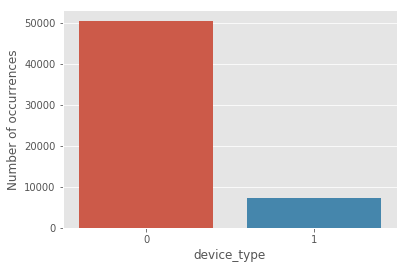

In [5]:
sns.countplot(df.device_type);
plt.xlabel('device_type');
plt.ylabel('Number of occurrences');

<Figure size 432x288 with 0 Axes>

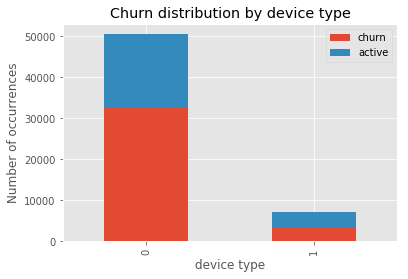

In [10]:
fig = plt.figure()
fig.set(alpha=0.2)

label_0 = df.device_type[df.label == 0].value_counts()
label_1 = df.device_type[df.label == 1].value_counts()
df_tmp = pd.DataFrame({u'churn':label_1, u'active':label_0})
df_tmp.plot(kind='bar', stacked=True)
plt.title(u"Churn distribution by device type")
plt.xlabel(u"device type") 
plt.ylabel(u"Number of occurrences") 
plt.show()

From the above plot, there seems to have higher churn/active ratio of iphone users than android users.

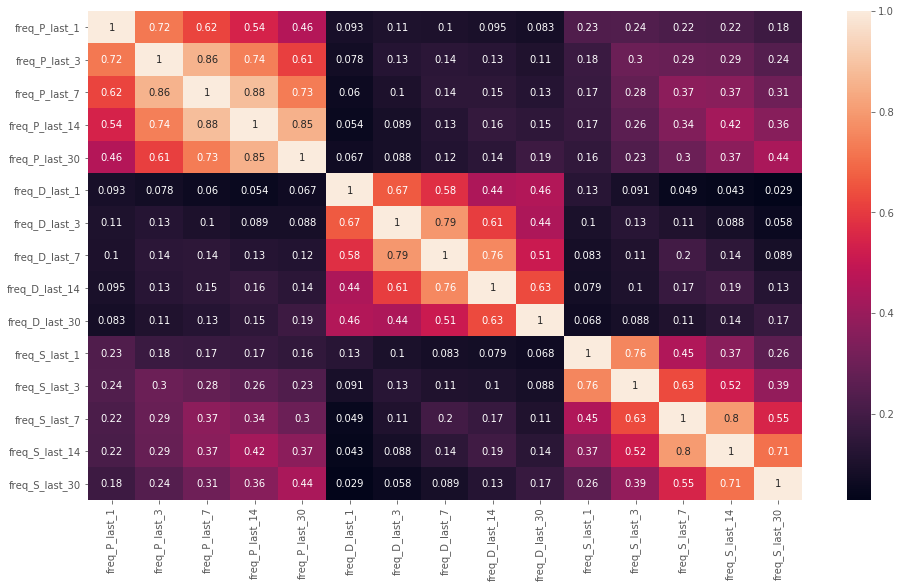

In [16]:
plt.subplots(figsize=(16,9))
correlation_mat = df[selected_features].corr()
sns.heatmap(correlation_mat, annot=True)

We also calculate the Pearson correlation coefficent to quantify correlations between the features (variables). This is a measure of the strength and direction of a linear relationship between two variables: a value of -1 means the two variables are perfectly negatively linearly correlated and a value of +1 means the two variables are perfectly positively linearly correlated. The above figure shows different values of the correlation coeffient and how they appear graphically.

We see a high correlation among a few features, for example, freq_P_last14 and freq_P_last7. But all these features we are interested and would like to keep all of those. Therefore, I will apply Ridge regression to reduce collinearity. Also, collinearity is especially problematic when a model purpose is explanation rather than prediction. 

## Define features and target

In [5]:
selected_features = list(df.columns.values)

In [6]:
selected_features.remove('uid')
selected_features.remove('label')
selected_features

['freq_P_last_1',
 'freq_P_last_3',
 'freq_P_last_7',
 'freq_P_last_14',
 'freq_P_last_30',
 'freq_D_last_1',
 'freq_D_last_3',
 'freq_D_last_7',
 'freq_D_last_14',
 'freq_D_last_30',
 'freq_S_last_1',
 'freq_S_last_3',
 'freq_S_last_7',
 'freq_S_last_14',
 'freq_S_last_30',
 'device_type']

In [7]:
X = df[selected_features]
y = df['label']

In [51]:
X.shape

(57804, 16)

In [52]:
y[:10]

0    1
1    0
2    0
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: label, dtype: int64

## Split dataset to train and test data

First, we split the data into training (80%) and testing sets (20%):

In [9]:
# import train test split function from sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Train model using sklearn

In [10]:
# define function to perform train, test, and get model performance
def train_test_model(clf, X_train, y_train, X_test, y_test):
    # Fit a model by providing X and y from training set
    clf.fit(X_train, y_train)

    # Make prediction on the training data
    y_train_pred = clf.predict(X_train)
    p_train_pred = clf.predict_proba(X_train)[:,1]

    # Make predictions on test data
    y_test_pred = clf.predict(X_test)
    p_test_pred = clf.predict_proba(X_test)[:,1]

    # print model results
    get_performance_metrics(y_train, p_train_pred, y_test, p_test_pred)
    plot_roc_curve(y_train, p_train_pred, y_test, p_test_pred)


### Calculate the metric scores for the model

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred):
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)

    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    plt.figure()
    lw = 2
    plt.plot(fpr_train, tpr_train, color='green',
             lw=lw, label='ROC Train (AUC = %0.4f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='darkorange',
             lw=lw, label='ROC Test (AUC = %0.4f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [12]:
# Import metrics functions from sklearn
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score

In [13]:
# Helper method to print metric scores    
def get_performance_metrics(y_train, y_train_pred, y_test, y_test_pred, threshold=0.5):
    metric_names = ['AUC','Accuracy','Precision','Recall','f1-score']
    metric_values_train = [roc_auc_score(y_train, y_train_pred),
                    accuracy_score(y_train, y_train_pred>threshold),
                    precision_score(y_train, y_train_pred>threshold),
                    recall_score(y_train, y_train_pred>threshold),
                    f1_score(y_train, y_train_pred>threshold)
                   ]
    metric_values_test = [roc_auc_score(y_test, y_test_pred),
                    accuracy_score(y_test, y_test_pred>threshold),
                    precision_score(y_test, y_test_pred>threshold),
                    recall_score(y_test, y_test_pred>threshold),
                    f1_score(y_test, y_test_pred>threshold)
                   ]
    all_metrics = pd.DataFrame({'metrics':metric_names,
                                'train':metric_values_train,
                                'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')
    print(all_metrics)

Since it is a binary classification problem, the data were fitted with 
* logistic regression 
* Random forest

### Fitting logstic regression model

              train      test
metrics                      
AUC        0.863385  0.859576
Accuracy   0.778323  0.777528
Precision  0.753910  0.753248
Recall     0.954814  0.950932
f1-score   0.842551  0.840625


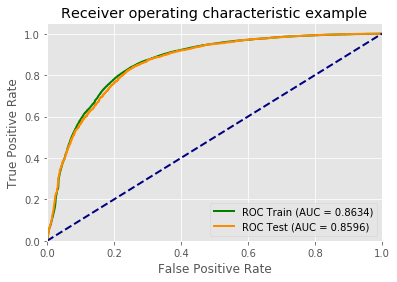

In [58]:
# Import logistic regression from sklearn
from sklearn.linear_model import LogisticRegression

# Initialize model by providing parameters
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
clf = LogisticRegression(C=1.0, penalty='l2')
# Fit a model by providing X and y from training set
clf.fit(X_train, y_train)

# Train test model
train_test_model(clf, X_train, y_train, X_test, y_test)

### Random Forest

              train      test
metrics                      
AUC        0.906953  0.891396
Accuracy   0.846247  0.829081
Precision  0.854756  0.841750
Recall     0.906531  0.890369
f1-score   0.879882  0.865377


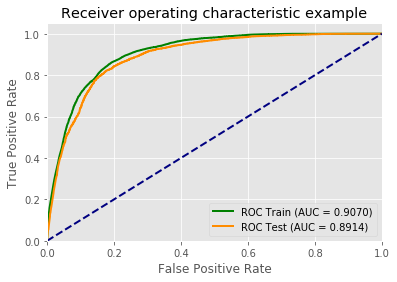

In [60]:
# fitting random forest
from sklearn.ensemble import RandomForestClassifier

# Choose some parameter combinations to try
parameters = {'n_estimators': 50,
              'max_features': 'auto',
              'criterion': 'gini',
              'max_depth': 20,
              'min_samples_split': 2,
              'min_samples_leaf': 20,
              'random_state': 0,
              'n_jobs': -1
              }

clf = RandomForestClassifier(**parameters)

# Fit a model by providing X and y from training set
clf.fit(X_train, y_train)

# Train test model
train_test_model(clf, X_train, y_train, X_test, y_test)

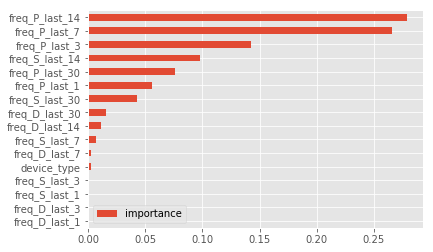

In [61]:
df_feature_importance = pd.DataFrame()
df_feature_importance['feature'] = selected_features
df_feature_importance['importance'] = clf.feature_importances_
df_feature_importance.sort_values('importance',inplace=True)

ax = df_feature_importance.plot.barh()
t = np.arange(len(df_feature_importance['feature']))
ax.set_yticks(t)
ax.set_yticklabels(df_feature_importance['feature'])
plt.show()

### HyperParameter Tuning: Grid Search

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier. 
clf = RandomForestClassifier()

# Choose some parameter combinations to try
param_grid = {'n_estimators': [100,200], 
              'max_features': ['auto'], 
              'criterion': ['gini'],
              'max_depth': [15,20,25], 
              'min_samples_split': [2],
              'min_samples_leaf': [2,10,20],
              'n_jobs':[-1]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(roc_auc_score)

# Run the grid search

grid_obj = GridSearchCV(clf, param_grid, cv=5, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

              train      test
metrics                      
AUC        0.917397  0.892220
Accuracy   0.857124  0.831243
Precision  0.864507  0.845007
Recall     0.913110  0.889668
f1-score   0.888144  0.866762


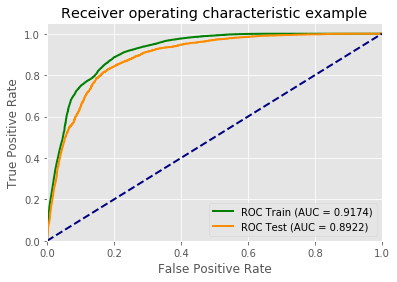

In [15]:
# Train test model
train_test_model(clf, X_train, y_train, X_test, y_test)

# Summary

I ran 2 classifier models and plotted their ROC curves. Their respective AUC (Area Under the Curve) measures are listed below:
* Logistic Regression 0.86
* Random Forest 0.89

we can see that Random Forest outperforms logistic regression model for user churn prediction based on AUC score after hperparameter tuning using grid search.

Random forest produced the higher AUC and the following scores:

* Accuracy: 83% labeled correctly
* Precision: 85% labeled as churn actually churned (15% were wrongly labeled as churn)
* Recall: 89% that actually churned were labeled as churn (11% of churn users were labeled as non-churn)

Throughout the analysis, I have learned several important things:

* Using my predictions, we can target our marketing campaign to the users we predict to churn.
* Features such as frequency of users playing music in the window period of 14 days or 7 days appear to play an important role in user churn. It provides us a timeline when we need to take actions to stop churn. For example, during thisperiod of time, we can send users reminder and recommend songs they might like.
* There does not seem to be a relationship between dervice type and churn.



# References
1. https://medium.com/@InDataLabs/effective-customer-churn-analysis-prediction-6fce3626f2c2
2. http://tesi.cab.unipd.it/53212/1/Valentino_Avon_-_1104319.pdf

